https://finance.yahoo.com/commodities/

https://gsnchez.com/blog/article/Optimizacion-algoritmica-de-carteras-con-markowitz

Importamos las librerias necesarias.

In [78]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

Descargamos el dataset a estudiar.

In [79]:
natural_gas = wb.DataReader('NG=F', data_source='yahoo', start='1900-1-1')

In [80]:
natural_gas.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,4.815,4.63,4.65,4.805,34954.0,4.805
2000-08-31,4.870,4.74,4.82,4.780,25787.0,4.780
2000-09-01,4.860,4.75,4.75,4.835,113.0,4.835
2000-09-05,4.975,4.84,4.85,4.960,26096.0,4.960
2000-09-06,5.110,4.96,4.99,5.065,32764.0,5.065


Transformamos el dataset a series de precios (Adj Close) anuales.

In [81]:
starts, ends = [], []
for i in range(1,22):
    starts.append('20{:02d}-01-01'.format(i))
    ends.append('20{:02d}-12-31'.format(i))

In [82]:
sd = np.std(natural_gas['Adj Close'].values)
natural_gas_years = pd.DataFrame()
for start, end in zip(starts, ends):
    s = [None] * 253
    v = natural_gas['Adj Close'][start:end].values
    v = (v - v[0]) / sd
    s[:len(v)] = v
    natural_gas_years[end[:4]] = s

In [83]:
natural_gas_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.064505,-0.088247,0.041660,0.114228,0.050171,-0.192172,-0.060921,-0.078840,0.045243,-0.110644,...,0.046139,-0.015678,-0.007615,-0.054202,-0.004032,-0.026877,-0.021502,-0.005823,0.003584,0.054202
2,0.284898,-0.085111,-0.141553,0.022845,0.019262,-0.504843,-0.061369,-0.004031,0.005375,0.055994,...,-0.005823,0.024189,-0.006719,-0.029117,-0.030013,-0.024189,-0.078840,0.038524,0.005823,0.060474
3,0.396886,-0.086455,-0.055546,0.119603,0.116020,-0.445266,-0.051515,0.012991,-0.044347,-0.034940,...,0.030909,0.014782,-0.009855,-0.059130,0.021502,-0.018814,-0.116916,-0.006271,0.017918,0.066297
4,0.598465,-0.082423,-0.040316,0.206058,0.094518,-0.553670,0.035388,0.052411,-0.173806,-0.060474,...,0.008063,-0.006719,-0.047035,-0.034044,0.061817,-0.100341,-0.098998,0.004032,0.008511,0.053306


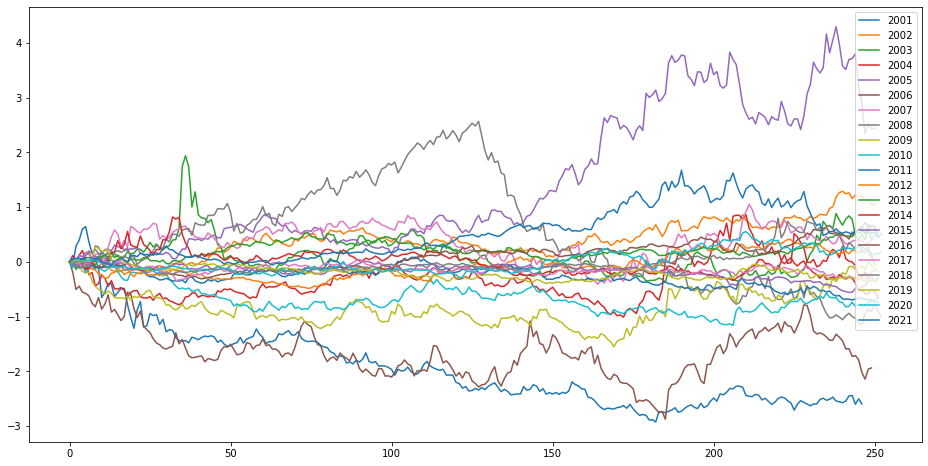

In [84]:
natural_gas_plot = natural_gas_years.plot(figsize=(16,8), legend=True, linewidth=1.5)

Obtenemos las matrices X e y. La matriz X tiene como columnas la variable año actual y la variable dia actual. La matriz y tiene los precios correspondientes a cada fila de X.

In [85]:
days = natural_gas_years.index.values
years = [int(year) for year in natural_gas_years.columns.values]

X = pd.DataFrame(columns=['year', 'day', 'y-1'])
y, i, n = np.array([None] * len(years) * len(days)), 0, 0
for year in years:
    for day in days:
        X.loc[i, 'year'], X.loc[i, 'day'] = year, day
        if year > years[0]:
            X.loc[i, 'y-1'] = y[n]
            n += 1
        y[i] = natural_gas_years[str(year)].values[day]
        i += 1

mask = ~np.isnan(list(y)) & ~np.isnan(list(X['y-1'].values))
X = X.loc[mask,:].reset_index(drop=True)
y = y[mask]

Iteramos entrenando un GP con kernel rbf sobre los años anteriores a n y el primer trimeste de n, y predecimos el resto del año n para n entre 2016 y 2021.

Predicting year 2011 with data from 2003 to 2010
Elapsed time: 53.482s
Log-marginal-likelihood: 1187.710
Predicting year 2012 with data from 2004 to 2011
Elapsed time: 49.058s
Log-marginal-likelihood: 840.093
Predicting year 2013 with data from 2005 to 2012
Elapsed time: 44.350s
Log-marginal-likelihood: 670.219
Predicting year 2014 with data from 2006 to 2013
Elapsed time: 29.155s
Log-marginal-likelihood: 709.563
Predicting year 2015 with data from 2007 to 2014
Elapsed time: 41.233s
Log-marginal-likelihood: 717.113
Predicting year 2016 with data from 2008 to 2015
Elapsed time: 29.791s
Log-marginal-likelihood: 796.763
Predicting year 2017 with data from 2009 to 2016
Elapsed time: 31.915s
Log-marginal-likelihood: 697.697
Predicting year 2018 with data from 2010 to 2017
Elapsed time: 42.838s
Log-marginal-likelihood: 536.308
Predicting year 2019 with data from 2011 to 2018
Elapsed time: 49.681s
Log-marginal-likelihood: 477.742
Predicting year 2020 with data from 2012 to 2019
Elapsed time: 

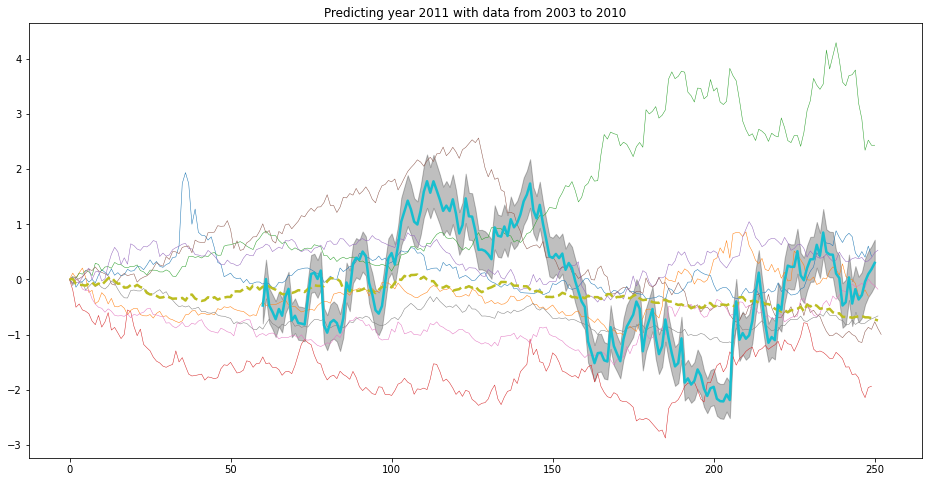

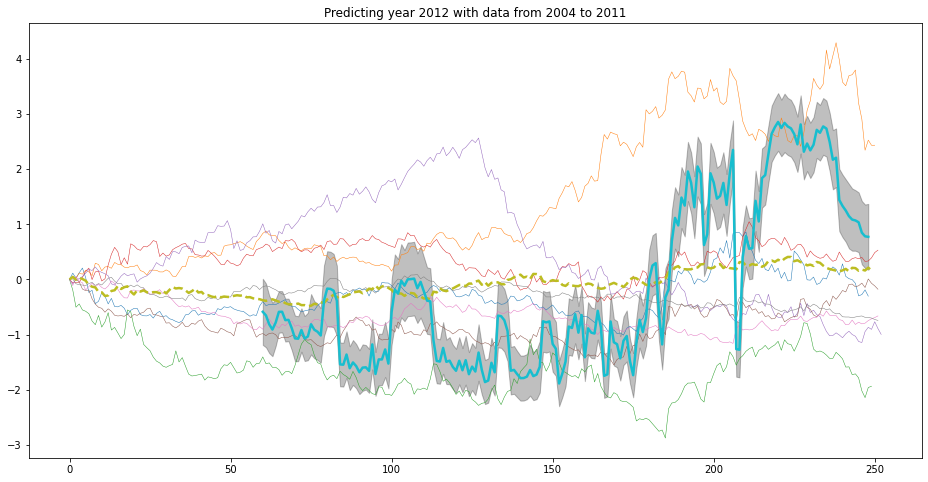

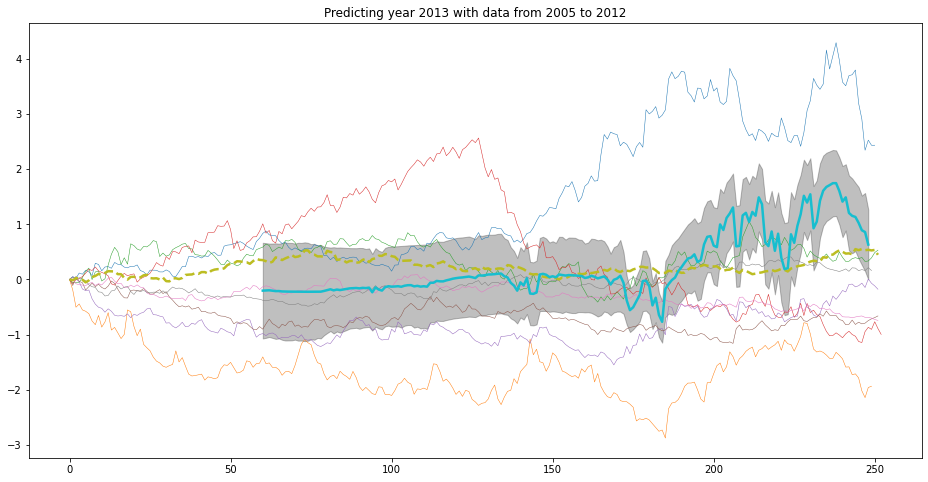

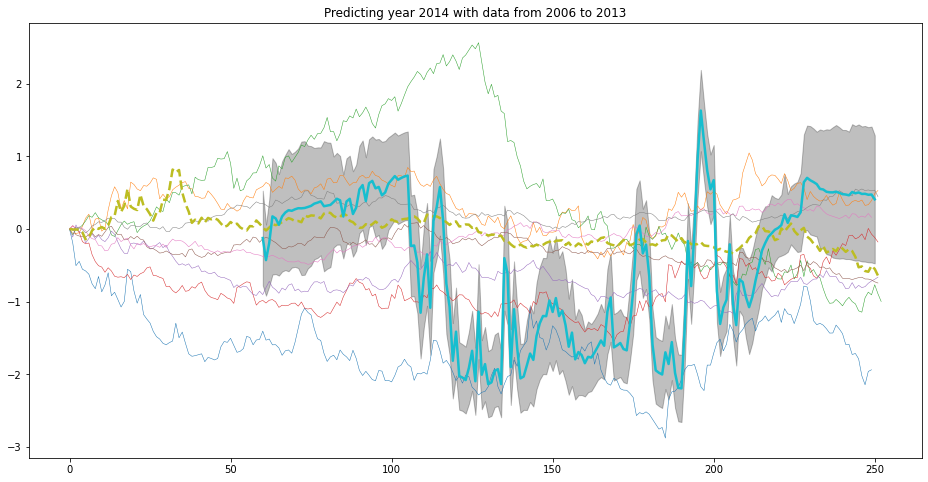

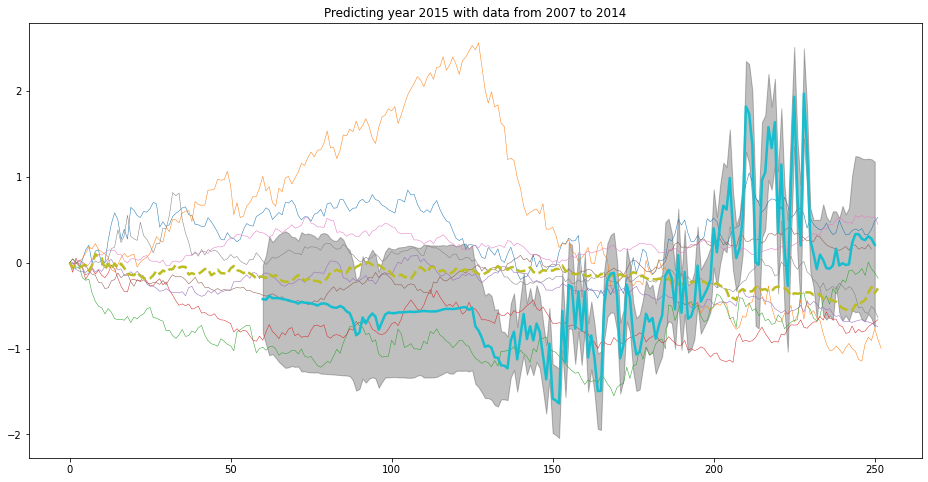

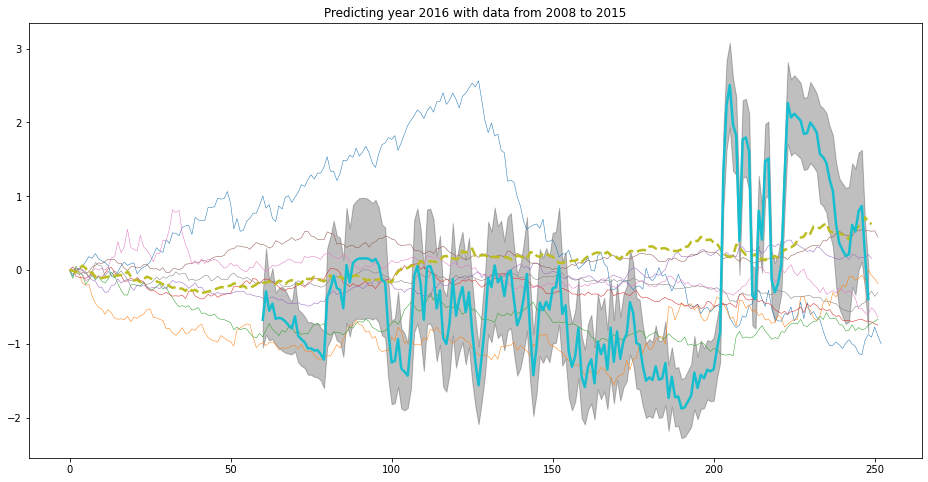

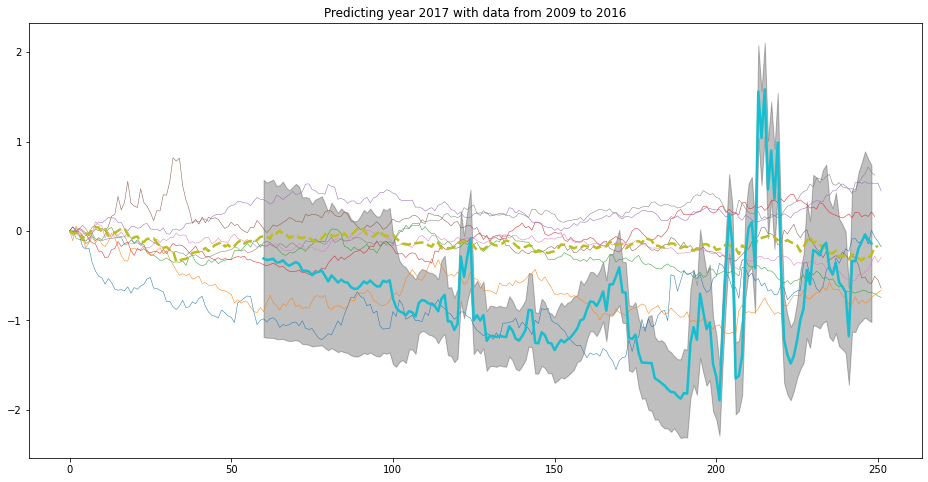

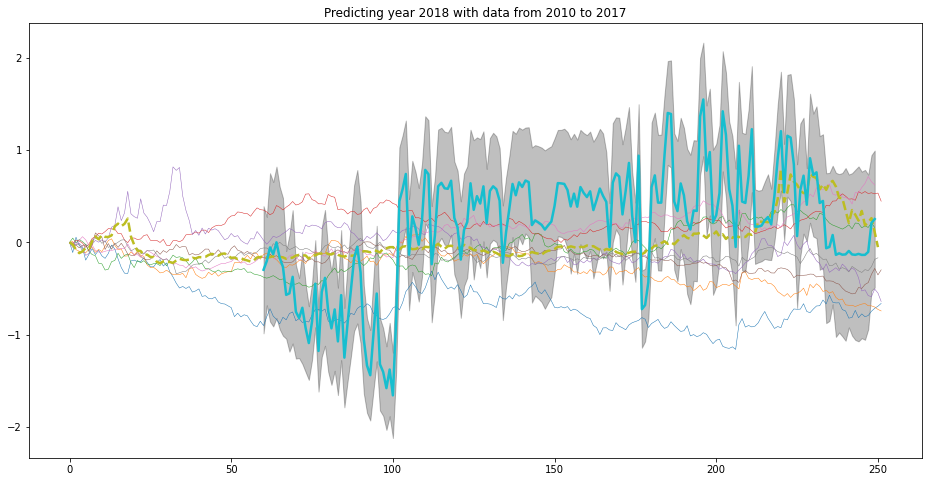

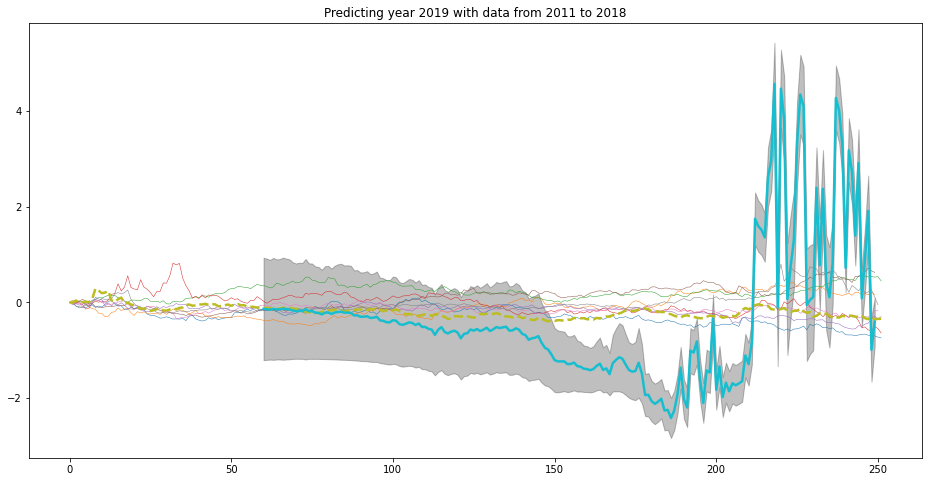

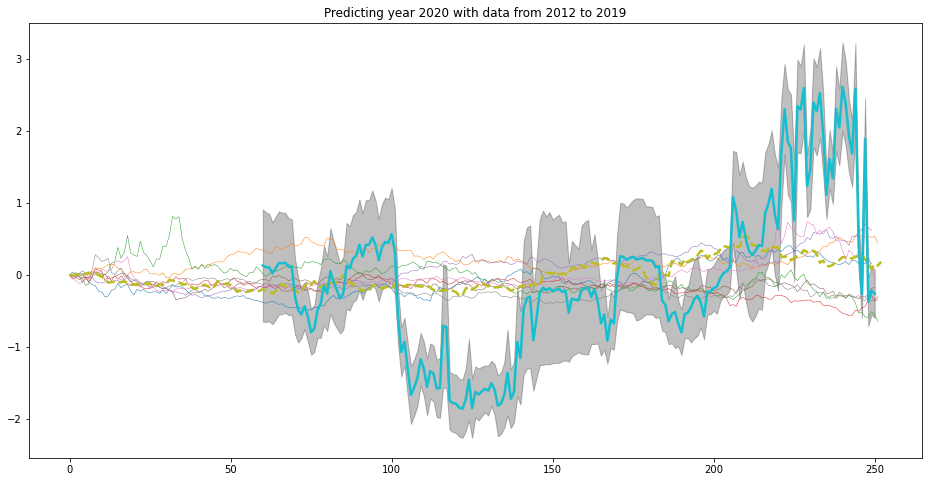

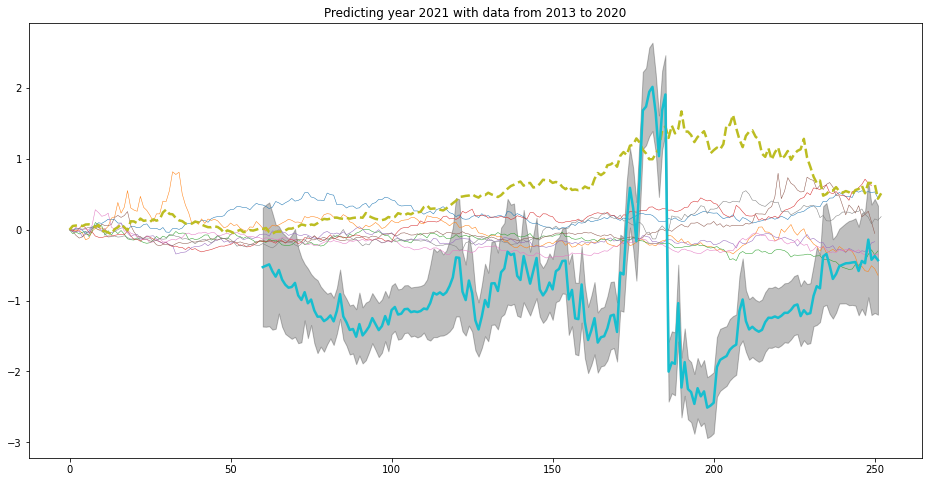

In [87]:
years_pred, days_pred, n_years = range(2011, 2022), 60, 8
for year_pred in years_pred:
    
    title = 'Predicting year {} with data from {} to {}'.format(year_pred, year_pred - n_years, year_pred - 1)
    print(title)
    
    X_train = X.loc[((X['year'] >= year_pred - n_years) & (X['year'] < year_pred)) | ((X['year'] == year_pred) & (X['day'] <= days_pred))]
    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns=['year', 'day', 'y-1'])
    y_train = y[X_train.index]
    
    X_test = X.loc[(X['year'] == year_pred) & (X['day'] > days_pred)]
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns=['year', 'day', 'y-1'])
    y_test = y[X_test.index]
    
    kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() * WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel,
                                  normalize_y=True,
                                  n_restarts_optimizer=1,
                                  random_state=2)
    t0 = time()
    gp.fit(X_train, y_train)
    print("Elapsed time: %0.3fs" % (time() - t0))
    print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    hco = natural_gas_years.loc[:,'{}-01-01'.format(year_pred - n_years - 1):'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.25, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}.png'.format(year_pred))